Meiosis pairing: MSCD and average linkages per chromosome
-------------------------------------------------------------------------

In [235]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import wlcstat.wlcave as wlcave
import wlcstat.wlcgreen as wlcgreen
import wlcstat.wlcstruc as wlcstruc
import wlcstat.poly_dyn as poly_dyn
import wlcstat.poly_confine as poly_confine

import pandas as pd

from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 12)

output_folder = Path('meiosis-figures-final/')

Determine the Kuhn length using the $T_{0}$ data from spo and wt data

In [236]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
nuc_radius = 1.3
linker_length = 15
radius_sq_cutoff = 0.250 ** 2

kuhn_length_0 = 0.015
kuhn_length_f = 0.450
n_kuhn = 30
kuhn_length_vec = np.linspace(kuhn_length_0, kuhn_length_f, n_kuhn)

mscd = np.array([])
mscd_biased = np.array([])

for i_kuhn in range(n_kuhn):
    kuhn_length = kuhn_length_vec[i_kuhn]

    chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
    total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
    locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
    cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
    label_loc_um = locus_position_kuhn * kuhn_length
    cent_loc_um = cent_position_kuhn * kuhn_length
    total_length_um = total_length_kuhn * kuhn_length
    n_cells = 1

    n_cells_biased = 0
    theory_plateaus = 0
    theory_plateaus_biased = 0
    for j in range(n_cells):
        cell = poly_dyn.generate_example_cell(0, total_length_um)
        cell = np.sort(np.append(cell, cent_loc_um))
        mscd_plateau_cell = poly_dyn.model_plateau(cell, label_loc_um, total_length_um, nuc_radius, kuhn_length)
        theory_plateaus += (1 / n_cells) * mscd_plateau_cell
        if mscd_plateau_cell > radius_sq_cutoff:
            n_cells_biased += 1
            theory_plateaus_biased += mscd_plateau_cell
    theory_plateaus_biased /= n_cells_biased
        
    mscd = np.append(mscd, theory_plateaus)
    mscd_biased = np.append(mscd_biased, theory_plateaus_biased)

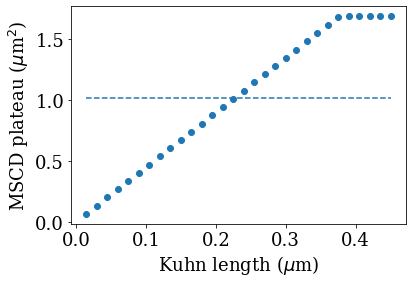

In [237]:
plateau_exp_ura = np.array([1.041056, 1.260354, 1.439587, 1.480568, 1.351417, 1.097409])
plateau_exp_spo = np.array([0.999832, 1.173121, 1.349847, 1.494605, 1.509391, 1.314366, 1.441702])
plateau_exp_0 = np.average([plateau_exp_ura[0],plateau_exp_spo[0]])

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(kuhn_length_vec, mscd_biased)
plt.plot(kuhn_length_vec, 0 * kuhn_length_vec + plateau_exp_0,'--')

plt.xlabel('Kuhn length ($\mu$m)')
plt.ylabel('MSCD plateau ($\mu$m$^2$)') 

plt.savefig('meiosis-figures-final/kuhn-eval.pdf', bbox_inches='tight')
plt.show()

kuhn_length = np.interp(plateau_exp_0, mscd_biased, kuhn_length_vec)

Determine the nuclear radius using the long-time values of the MSCD plateau

In [238]:
plateau_exp_longtime = np.average([1.494605, 1.509391, 1.441702])

In [239]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_radius_0 = 1
nuc_radius_f = 2
n_nuc = 50
nuc_radius_vec = np.linspace(nuc_radius_0, nuc_radius_f, n_nuc)

r2_theory = np.zeros(n_nuc)
for i_nuc in range(n_nuc):
    nuc_radius = nuc_radius_vec[i_nuc]
    r2_theory[i_nuc] = 2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500)

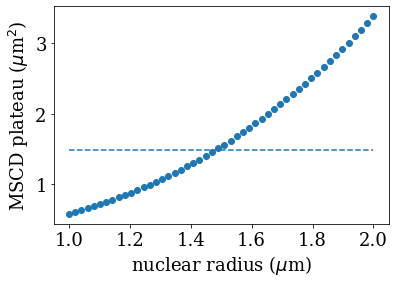

In [240]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(nuc_radius_vec, r2_theory)
plt.plot(nuc_radius_vec, 0*nuc_radius_vec + plateau_exp_longtime,'--')

plt.xlabel('nuclear radius ($\mu$m)')
plt.ylabel('MSCD plateau ($\mu$m$^{2}$)') 

plt.savefig('meiosis-figures-final/radius-eval.pdf', bbox_inches='tight')
nuc_radius = np.interp(plateau_exp_longtime, r2_theory, nuc_radius_vec)

Determine the fraction of cells in Rabl configuration based on the fitted Kuhn length and linker length. Evaluate the rate constant of centromere detachment

In [241]:
frac_rabl = np.minimum((plateau_exp_spo - plateau_exp_longtime) / (plateau_exp_0 - plateau_exp_longtime), np.ones(7))

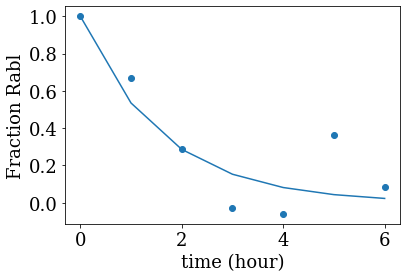

In [242]:
time_exp = np.linspace(0,6,7)
p_rabl = np.polyfit(time_exp[0:3], np.log(frac_rabl[0:3]),1)
k_rabl = -p_rabl[0]

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


plt.scatter(time_exp, frac_rabl)
plt.plot(time_exp, np.exp(-k_rabl * time_exp),'-')

plt.xlabel('time (hour)')
plt.ylabel('Fraction Rabl') 

plt.savefig('meiosis-figures-final/frac_rabl.pdf', bbox_inches='tight')
plt.show()

Evaluate the MSCD and biased MSCD at the fitted kuhn length and linker length

In [243]:
linker_length = 15

chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])

mus = np.linspace(0, 20, 101)
n_cells = 100000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))

mscd_fit = np.zeros_like(mus)
mscd_fit_biased = np.zeros_like(mus)
mscd_rabl_fit = np.zeros_like(mus)
mscd_rabl_fit_biased = np.zeros_like(mus)
for i, mu in enumerate(mus):
    n_cells_biased = 0
    n_cells_rabl_biased = 0    
    for j in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        mscd_fit[i] += (1 / n_cells) * mscd_plateau_cell
        if mscd_plateau_cell > radius_sq_cutoff:
            n_cells_biased += 1
            mscd_fit_biased[i] += mscd_plateau_cell 
            
        cell = np.sort(np.append(cell, cent_loc_um))
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        mscd_rabl_fit[i] += (1 / n_cells) * mscd_plateau_cell
        if mscd_plateau_cell > radius_sq_cutoff:
            n_cells_rabl_biased += 1
            mscd_rabl_fit_biased[i] += mscd_plateau_cell
    mscd_rabl_fit_biased[i] /= n_cells_rabl_biased
    mscd_fit_biased[i] /= n_cells_biased


In [244]:
nuc_plateau

1.2172565357425331

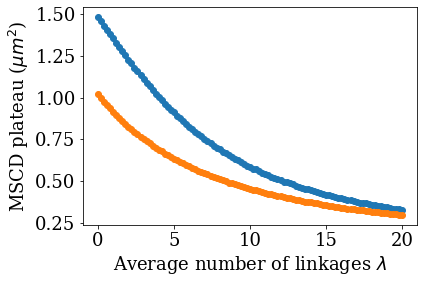

In [245]:
plt.scatter(mus, mscd_fit_biased)
plt.scatter(mus, mscd_rabl_fit_biased)

plt.xlabel('Average number of linkages $\lambda$')
plt.ylabel('MSCD plateau ($\mu{}m^2$)') 

plt.show()

Evaluate the average number of linkages by fitting the ura3 data

In [246]:
time_exp = np.linspace(0,6,7)
mu_fit_ura = np.zeros(7)
mscd_fit_ura = np.zeros(7)
mscd_fit_spo = np.zeros(7)
for i_exp in range(len(plateau_exp_ura)):
    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mscd_combo_fit_biased = frac_rabl * mscd_rabl_fit_biased + (1 - frac_rabl) * mscd_fit_biased
    mu_fit_ura[i_exp] = np.interp(plateau_exp_ura[i_exp], np.flipud(mscd_combo_fit_biased), np.flipud(mus))
    
    mscd_fit_ura[i_exp] = np.interp(mu_fit_ura[i_exp], mus, mscd_combo_fit_biased)
    mscd_fit_spo[i_exp] = mscd_combo_fit_biased[0]

i_exp = 6
frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
mscd_combo_fit_biased = frac_rabl * mscd_rabl_fit_biased + (1 - frac_rabl) * mscd_fit_biased
mscd_fit_spo[i_exp] = mscd_combo_fit_biased[0]

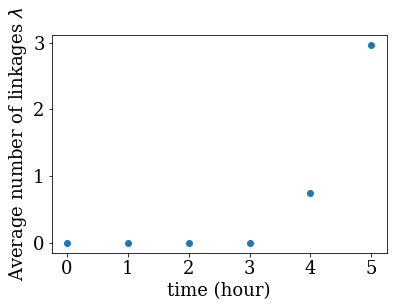

array([0.        , 0.        , 0.        , 0.        , 0.74337773,
       2.96185379, 0.        ])

In [247]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(time_exp[0:6], mu_fit_ura[0:6])

plt.ylabel('Average number of linkages $\lambda$')
plt.xlabel('time (hour)')

plt.savefig('meiosis-figures-final/ave_link.pdf', bbox_inches='tight')
plt.show()

mu_fit_ura

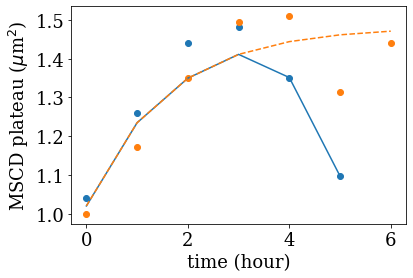

In [248]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(time_exp[0:6], mscd_fit_ura[0:6],'-')
plt.plot(time_exp, mscd_fit_spo,'--')
plt.scatter(time_exp[0:6], plateau_exp_ura)
plt.scatter(time_exp, plateau_exp_spo)

plt.ylabel('MSCD plateau ($\mu$m$^2$)') 
plt.xlabel('time (hour)')

plt.savefig('meiosis-figures-final/mscd_fit.pdf', bbox_inches='tight')
plt.show()

Fit the diffusivity using the URA3 data over time

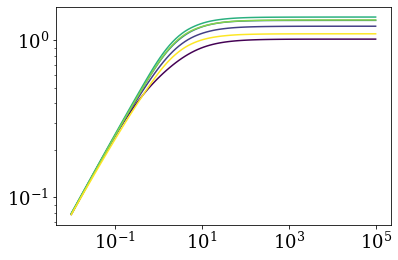

In [249]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
d0 = 1

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))

time_0 = 0.01
time_f = 100000
n_time = 100
time_theory_total = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time_theory_total, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased
    
    mscd_theory_total = np.append(mscd_theory_total, mscd_theory_exp_d)
    
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time_theory_total, mscd_theory_exp_d,'-',c=viridis(color_ratio))

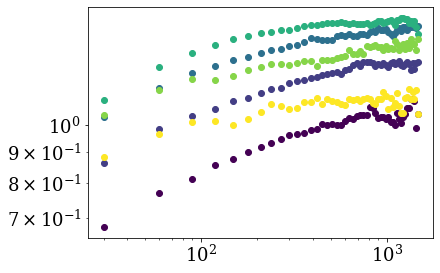

In [250]:
d_scale_0 = 0.105
d_scale_f = 0.11
n_d = 40
d_scale_vec = np.linspace(d_scale_0, d_scale_f, n_d)

fit_ssr = np.zeros(n_d)

msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    if i_exp < 6:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))
    
        ind0 = n_time * i_exp
        indf = n_time * i_exp + n_time
    
        for i_d in range(n_d):
            d_scale = d_scale_vec[i_d]
            mscd_fit = np.interp(time_data, time_theory_total / d_scale, mscd_theory_total[ind0:indf])
            
            fit_ssr[i_d] += np.sum((np.log10(mscd_fit / mscd_data)) ** 2)
    
    i_exp += 1


0.10274384918255644

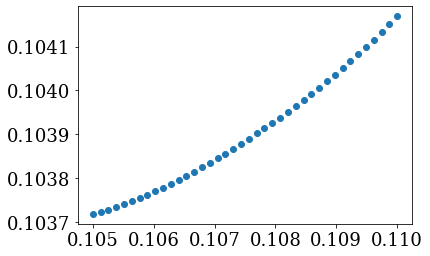

In [251]:
plt.figure()
plt.scatter(d_scale_vec, fit_ssr)

p_ssr = np.polyfit(d_scale_vec, fit_ssr, 2)
d_scale_min = - p_ssr[1] / (2 * p_ssr[0]) 
d_scale_min

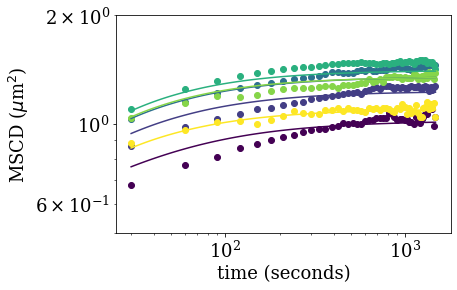

In [88]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
#ax.set_yscale('log')
#ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    if i_exp < 6:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
d0 = d_scale_min

n_cells = 10000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
#csfont = {'fontname':'Times New Roman'}

#ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
plt.ylim((0.5, 2))  
    
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_ura3.pdf', bbox_inches='tight')
plt.show()

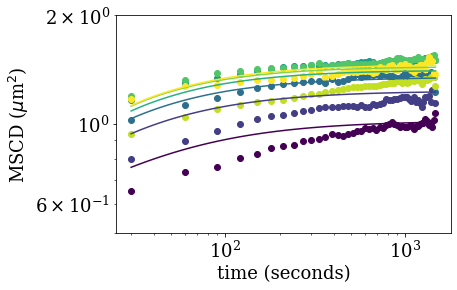

In [89]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'SP')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

#ax.set_yscale('log')
#ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_spo)-1)
    if i_exp < 7:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
d0 = d_scale_min

n_cells = 10000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = 0
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
#csfont = {'fontname':'Times New Roman'}

#ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
plt.ylim((0.5, 2))

        
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_spo.pdf', bbox_inches='tight')
plt.show()

In [99]:
d_scale_min

0.10754777916881338

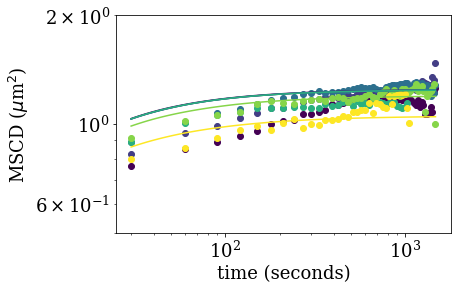

In [90]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('LYS2', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

#ax.set_yscale('log')
#ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = (i_exp - 1) / (6 - 1)
    if i_exp < 7 and i_exp > 0:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 813184
nucleo_length = 146
locus_position_bp = np.mean([469748, 473926])
cent_position_bp = np.mean([238207, 238323])

d0 = d_scale_min

n_cells = 10000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
#csfont = {'fontname':'Times New Roman'}

#ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
plt.ylim((0.5, 2))  

        
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_lys_t1_t6.pdf', bbox_inches='tight')
plt.show()

/Users/ajspakow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


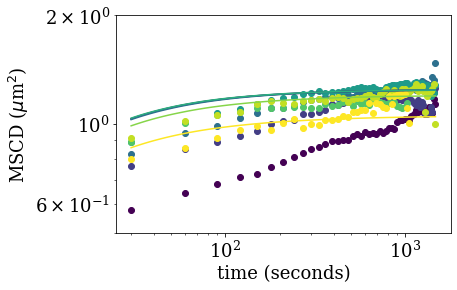

In [91]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('LYS2', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (7 - 1)
    if i_exp < 7 and i_exp > -1:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 813184
nucleo_length = 146
locus_position_bp = np.mean([469748, 473926])
cent_position_bp = np.mean([238207, 238323])

d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
#csfont = {'fontname':'Times New Roman'}

#ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
plt.ylim((0.5, 2))  
        
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_lys_t0_t6.pdf', bbox_inches='tight')
plt.show()

In [97]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])


d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))
print(nuc_plateau)

1.2172565357425331


Fit the diffusivity at $T_{0}$ and compare to URA3 and LYS2

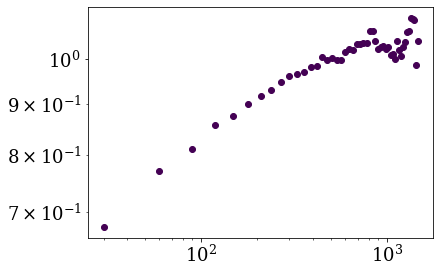

In [262]:
d_scale_0 = 0.06
d_scale_f = 0.09
n_d = 40
d_scale_vec = np.linspace(d_scale_0, d_scale_f, n_d)

fit_ssr = np.zeros(n_d)

msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    if i_exp < 1:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))
    
        ind0 = n_time * i_exp
        indf = n_time * i_exp + n_time
        time_data_t0 = time_data
        mscd_data_t0 = mscd_data
    
        for i_d in range(n_d):
            d_scale = d_scale_vec[i_d]
            mscd_fit = np.interp(time_data, time_theory_total / d_scale, mscd_theory_total[ind0:indf])
            
            fit_ssr[i_d] += np.sum((np.log10(mscd_fit / mscd_data)) ** 2)
    
    i_exp += 1



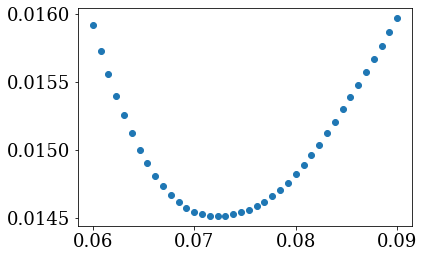

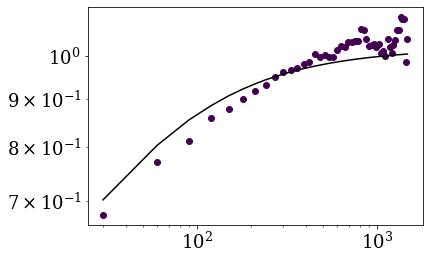

In [263]:
plt.figure()
plt.scatter(d_scale_vec, fit_ssr)

p_ssr = np.polyfit(d_scale_vec, fit_ssr, 2)
d_scale_min_t0 = - p_ssr[1] / (2 * p_ssr[0]) 

plt.show()

plt.figure()
mscd_fit = np.interp(time_data_t0, time_theory_total / d_scale_min_t0, mscd_theory_total[ind0:indf])

color_ratio = 0
plt.loglog(time_data_t0, mscd_data_t0,'o', c=viridis(color_ratio))
plt.loglog(time_data_t0, mscd_fit,'k-')






In [264]:
d_scale_min_t0

0.07393278130006668

Plateau values

In [20]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
linker_length = 15
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

print(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))


1.4815368587554956
1.4815368587554956


In [21]:
chr_size_bp = 813184
nucleo_length = 146
locus_position_bp = np.mean([469748, 473926])
cent_position_bp = np.mean([238207, 238323])

linker_length = 15
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

print(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))



1.2455122951956685
1.2455122951956685


In [100]:
kuhn_length

0.2270063454533093

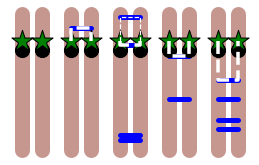

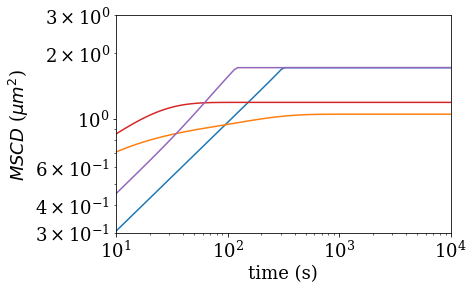

In [461]:
mu = 2.96
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])

kuhn_length = 0.15

d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        


cells = [poly_dyn.generate_example_cell(mu,total_length_um) for i in range(5)]
ax, all_closest_links = poly_dyn.draw_cells(cells, min_y=0.05, max_y=0.95, 
                                            locus_frac=1-label_loc_um/total_length_um, 
                                            centromere_frac=1-cent_loc_um/total_length_um,
                                            chr_size = total_length_um)
    
plt.savefig('meiosis-figures-final/cell-connect.pdf', bbox_inches='tight')
plt.show()

t = np.logspace(1,4,100).astype(float)

plt.figure()
for i, linkages in enumerate(cells):
    d_cell = d0 * np.random.exponential()
    mscd_cell = poly_dyn.model_mscd(t,linkages,label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
    plt.loglog(t, mscd_cell, label = 'Cell ' + str(i+1))
#plt.legend()

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.ylim((0.3, 3))  
plt.xlim((10,10000))

plt.savefig('meiosis-figures-final/mscd-theory.pdf', bbox_inches='tight')
plt.xlabel(r'time (s)')
plt.ylabel(r'$MSCD$ ($\mu m^{2}$)')
plt.show()

In [119]:
check = np.arange(0,10).astype(float)
np.zeros_like(check)
poly_confine.eval_r2_surf(check, 10,1)

array([0.99918902, 0.28526386, 0.28269137, 0.28267288, 0.28267274,
       0.28267274, 0.28267274, 0.28267288, 0.28269137, 0.28526386])

In [137]:
kuhn_length

0.2270063454533093

In [149]:
nuc_plateau

1.2172565357425331

In [394]:
cells

[array([10.67219874]),
 array([ 6.36951608, 16.58858648, 17.59919823]),
 array([ 1.50397653, 15.11681736]),
 array([ 3.5843432 , 10.31057182]),
 array([ 5.85864143, 15.77187048])]

In [193]:
d0

0.10754777916881338

In [234]:
kuhn_length

0.15

In [373]:
d_scale_min

0.10274384918255644

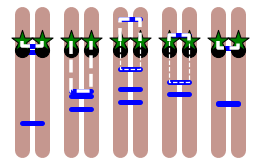

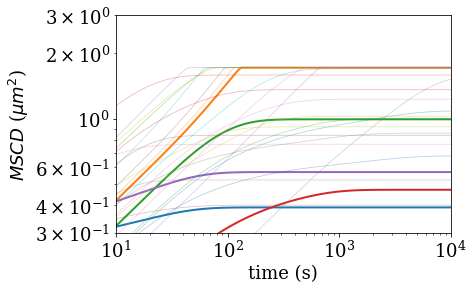

In [546]:
mu = 2.96
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])

kuhn_length = 0.15

d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        


cells = [poly_dyn.generate_example_cell(mu,total_length_um) for i in range(5)]
#cells = np.array([
#    np.array([ 6.27691595,  6.67602814,  7.39319476,  7.58436022, 10.70056566, 14.53171193, 17.50067875]), 
#    np.array([ 1.88285747,  5.50986655,  7.09071582,  9.35419473, 11.51684091, 14.78324998]), 
#    np.array([10.16090374, 15.67660319, 17.56317468]), 
#    np.array([ 1.63040091, 17.62543645]),
#    np.array([ 8.35758304, 11.98909254, 13.68925127])])
ax, all_closest_links = poly_dyn.draw_cells(cells, min_y=0.05, max_y=0.95, 
                                            locus_frac=1-label_loc_um/total_length_um, 
                                            centromere_frac=1-cent_loc_um/total_length_um,
                                            chr_size = total_length_um)
    
plt.savefig('meiosis-figures-final/cell-connect.pdf', bbox_inches='tight')
plt.show()

t = np.logspace(1,4,100).astype(float)

plt.figure()

for i, linkages in enumerate(cells):
    d_cell = d0 * np.random.exponential()
    mscd_cell = poly_dyn.model_mscd(t,linkages,label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
    plt.loglog(t, mscd_cell, label = 'Cell ' + str(i+1), alpha=1, lw=2)
#plt.legend()


cells_total = [poly_dyn.generate_example_cell(mu,total_length_um) for i in range(25)]

for i, linkages in enumerate(cells_total):
    d_cell = d0 * np.random.exponential()
    mscd_cell = poly_dyn.model_mscd(t,linkages,label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
    plt.loglog(t, mscd_cell, label = 'Cell ' + str(i+1), alpha=0.35, lw=0.75)

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.ylim((0.3, 3))  
plt.xlim((10,10000))

plt.savefig('meiosis-figures-final/mscd-theory-full.pdf', bbox_inches='tight')
plt.xlabel(r'time (s)')
plt.ylabel(r'$MSCD$ ($\mu m^{2}$)')
plt.show()

In [502]:
cells

[array([ 6.27691595,  6.67602814,  7.39319476,  7.58436022, 10.70056566,
        14.53171193, 17.50067875]),
 array([ 1.88285747,  4.59028998,  5.50986655,  7.09071582,  9.35419473,
        11.51684091, 14.78324998]),
 array([10.16090374, 15.67660319, 17.56317468]),
 array([ 5.63040091, 17.62543645]),
 array([ 8.35758304, 11.98909254, 13.68925127])]